In [1]:
import numpy as np
import cv2
import glob
from functions import *
from matplotlib import pyplot as plt
from itertools import count

In [2]:
CAMERA_ID = 'david'
SESSION_ID = '13-04-2021b'
PROCESSED_IMAGE_NAME = 'result_247_247_4_7.png'
CHESSBOARD_SQUARE_LENGTH_MM = 1
CHESSBOARD_DIMENSIONS = (9,6, CHESSBOARD_SQUARE_LENGTH_MM)
PLANE_CALIBRATION_OBJECT_HEIGHT_MM = 2

## Chessboard calibration (intrisinc parameters)

In [3]:
object_points, image_points, image_dimensions = chessboardIntrinsicCalibration(CHESSBOARD_DIMENSIONS,f'data/calibration/{CAMERA_ID}/intrinsic')


100%|██████████| 20/20 [00:13<00:00,  1.46it/s]
Calibration over



### Intrinsic Parameters

In [4]:
ret, intrinsic_matrix, distortion_coefs, rotation_vecs, translation_vecs = cv2.calibrateCamera(object_points, image_points, image_dimensions,None,None)
print('Image Dimensions\n', image_dimensions)
print('Intrinsic Matrix\n', intrinsic_matrix)
print('Distortion Coefficients\n', distortion_coefs)
print('Rotation Vectors\n', rotation_vecs)
print('Translation Vectors\n', translation_vecs)

Image Dimensions
 (1280, 720)
Intrinsic Matrix
 [[9.95501374e+02 0.00000000e+00 6.59362830e+02]
 [0.00000000e+00 1.00107125e+03 3.60433162e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients
 [[ 0.27103847 -0.58181555 -0.02118469  0.00707566  0.56085949]]
Rotation Vectors
 [array([[ 2.08127707],
       [-2.09044261],
       [ 0.27168127]]), array([[ 1.65084257],
       [ 2.41501087],
       [-0.23927253]]), array([[ 0.04104214],
       [ 2.9664063 ],
       [-0.37563987]]), array([[-0.04790192],
       [ 3.0160093 ],
       [-0.36130581]]), array([[ 1.04977134],
       [ 2.77734585],
       [-0.29010723]]), array([[ 2.9204664 ],
       [-0.02701965],
       [ 0.03010079]]), array([[ 2.2521635 ],
       [ 1.76332135],
       [-0.11722763]]), array([[ 2.64616978],
       [ 1.08315951],
       [-0.05119949]]), array([[-0.12313616],
       [ 3.05119573],
       [-0.27007403]]), array([[-0.78736026],
       [ 2.9573973 ],
       [-0.3248312 ]]), array([[2.74664385]

### Intrinsic Reprojection Error

In [5]:
print(f'Reprojection error: {calculateReprojectionError(object_points, image_points, rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)}')

Reprojection error: 0.049253993638239124


## Chessboard calibration (extrinsic parameters)

In [6]:
object_points, image_points = chessboardExtrinsicCalibration(CHESSBOARD_DIMENSIONS, f'data/calibration/{CAMERA_ID}/{SESSION_ID}/extrinsic')

100%|██████████| 20/20 [00:01<00:00, 17.45it/s]Object points shape: (1080, 3)
Image points shape: (1080, 1, 2)



In [7]:
    # Calculate extrinsic parameter matrices (translation and rotation) using PNP RANSAC
    ret, rotation_vecs, translation_vecs, _ = cv2.solvePnPRansac(object_points, image_points, intrinsic_matrix, distortion_coefs)

### Extrinsic Reprojection Error

In [8]:
mean_error = 0

for i in range(len(object_points)):
    calulated_image_points, _ = cv2.projectPoints(object_points[i], rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)
    error = cv2.norm(image_points[i],calulated_image_points[0], cv2.NORM_L2)/len(calulated_image_points)
    mean_error += error

print(f'Reprojection error: {mean_error/len(object_points)}')

Reprojection error: 5.023792816689773


## Projection Calculation

In [9]:
perspective_projection_matrix = calculatePpmMatrix(intrinsic_matrix, rotation_vecs, translation_vecs)

## Shadow/Light Plane Calibration

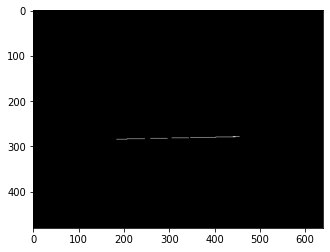

In [11]:
TEMP_SESSION = '13-04-2021b'
flat_image = cv2.imread(f'data/calibration/{CAMERA_ID}/{TEMP_SESSION}/shadow_flat/frame_2021-04-13 21:39:34.254860.png',cv2.IMREAD_GRAYSCALE)
height_image = cv2.imread(f'data/calibration/{CAMERA_ID}/{TEMP_SESSION}/shadow_height/intrujice.png', cv2.IMREAD_GRAYSCALE)
processed_bottom = cv2.imread(f'data/calibration/{CAMERA_ID}/{TEMP_SESSION}/shadow_flat/result_231_233_5_8-clean-clean.png', cv2.IMREAD_GRAYSCALE)
top_lines = cv2.subtract(height_image, processed_bottom)
ret, processed_top = cv2.threshold(top_lines, 240, 255, cv2.THRESH_BINARY)

processed_bottom = processed_bottom
processed_top = height_image
plt.imshow(processed_bottom, cmap='gray')

In [12]:
# Map image 2D coordinates to 3D coordinates

bottom_points = []
top_points = []
shadow_plane_3d_points = []

# 'Floor' points
white_pixel_coords = cv2.findNonZero(processed_bottom)
for pixel in white_pixel_coords:
    point = get_xyz_coords(pixel[0,0],pixel[0,1], perspective_projection_matrix, [[0,0,1,0]]) # z = 0
    bottom_points.append(point)

# Object top points
white_pixel_coords = cv2.findNonZero(processed_top)
for pixel in white_pixel_coords:
    point = get_xyz_coords(pixel[0,0],pixel[0,1], perspective_projection_matrix, [[0,0,1, PLANE_CALIBRATION_OBJECT_HEIGHT_MM]]) # z = PLANE_CALIBRATION_OBJECT_HEIGHT
    top_points.append(point)

# TODO: fix this ad hoc way of assuring the number of top points is the same as the number of bottom points
bottom_points = bottom_points[len(bottom_points)//2 -len(top_points)//2 : len(bottom_points)//2 + len(top_points) // 2]
shadow_plane_3d_points = bottom_points
shadow_plane_3d_points.extend(top_points)

In [13]:
# Calculate A,B,C and D parameters of the light/shadow plane using least squares method
# plane_points = np.hstack((shadow_plane_3d_points, np.ones((len(shadow_plane_3d_points), 1)) * -1))
# res = np.linalg.lstsq(plane_points, np.zeros((len(plane_points))), rcond=None)
# print(res)

In [14]:
plane_coefs = calculatePlaneCoefs(np.array(shadow_plane_3d_points))

[-5.515036462043707, 0.3390495123555954, -1.0, 2.8887355342839465]

## Target object point extraction

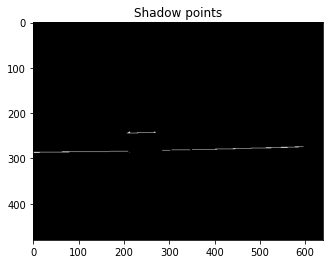

In [15]:
shadow_points = cv2.imread(f'data/calibration/{CAMERA_ID}/{SESSION_ID}/cube_processed/{PROCESSED_IMAGE_NAME}')
shadow_points_gray = cv2.cvtColor(shadow_points, cv2.COLOR_BGR2GRAY)
plt.title('Shadow points')
plt.imshow(shadow_points, cmap='gray')

In [16]:
# Calculate y and z for points in shadow
points_x = []
points_y = []
points_z = []
white_pixel_coords = cv2.findNonZero(shadow_points_gray)
for pixel in white_pixel_coords:
    x, y, z = get_xyz_coords(pixel[0,0],pixel[0,1], perspective_projection_matrix, [plane_coefs])
    points_y.append(y)
    points_z.append(z)
    points_x.append(x)

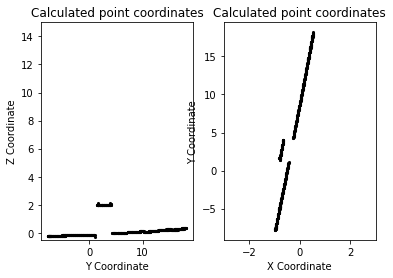

In [17]:
figure, subplots = plt.subplots(1, 2)
subplots[0].set_title('Calculated point coordinates')
subplots[0].set_xlabel('Y Coordinate')
subplots[0].set_ylabel('Z Coordinate')
subplots[0].set_ylim([-0.5,15])
subplots[0].scatter(points_y, points_z, color='black', marker='.', linewidths=0.1)

subplots[1].set_title('Calculated point coordinates')
subplots[1].set_xlabel('X Coordinate')
subplots[1].set_ylabel('Y Coordinate')
subplots[1].set_xlim([-3,3])
subplots[1].scatter(points_x, points_y, color='black', marker='.', linewidths=0.1)